# Równoważenia obciążenia przez alokację shardów

Inicjalizacja środowiska

In [1]:
import pprint
import operator
import numpy as np
import matplotlib.pyplot as plt

pp = pprint.PrettyPrinter(indent=1, width=140)

Inicjalizacja wektora obciążeń poszczególnych shardów (F)

In [2]:
np.random.seed(23456789)

F = np.random.randint(1,9, size=(250, 100))
pp.pprint(F)
print(np.array(F).shape)

array([[7, 7, 7, ..., 2, 6, 8],
       [8, 6, 6, ..., 7, 1, 3],
       [5, 3, 5, ..., 2, 1, 5],
       ...,
       [2, 6, 7, ..., 1, 4, 8],
       [5, 8, 1, ..., 3, 7, 7],
       [8, 2, 4, ..., 3, 2, 8]])
(250, 100)


Wyznaczenie ilości węzłów chmury (n)

In [3]:
n = 30

Wyznaczenie sumarycznego wektora obciążenia całej chmury

In [4]:
wts = map(sum, zip(*F))

Wyznaczenie względnego obciążenia przypadającego na jeden węzeł chmury

In [5]:
nwts = sum(list(wts))

Sortowanie względem modułu

In [6]:
F=sorted([x * n for x in F],key=sum)

Alokowanie wektorów shardów względem posortowanego obciążenia

In [7]:
N = [[0 for y in F[x]] for x in range(0, n)]
for shard in F:
    abs1 = sum(map(abs,map(operator.sub, wts,shard)))
    maxValue = None
    maxNodeIndex = None

    for index, node in enumerate(N):
        
        if(sum(node) >= nwts):
            continue
            
        temp = [node,shard]
        abs2 =  sum(map(abs,map(operator.sub, wts, [sum(x) for x in zip(*temp)])))
        
        value=abs2-abs1
        
        if(maxValue is None or value > maxValue):
            maxValue=value
            maxNodeIndex=index
    
    # suma dwoch wektorow
    N[maxNodeIndex]=list(map(operator.add, N[maxNodeIndex], list(shard)))

#powrocenie do zmniejszonej o n 
N=[[x/n for x in f] for f in N]

Określenie średniej mocy chmury

In [8]:
power = 20

Wyznaczenie średniego obciążenia w czasie każdego węzła chmury

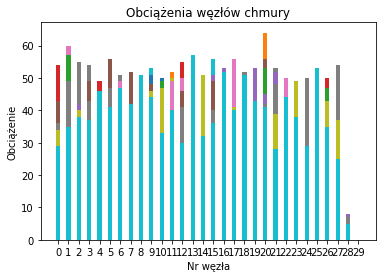

In [9]:
width = 0.4
Narray = np.transpose(np.array(N))

ind = np.arange(n)
for index, value in enumerate(N):
    plt.bar(range(0,n ), list(Narray[index]), width)
    
plt.xlabel("Nr węzła")
plt.ylabel("Obciążenie")
plt.xticks(range(0,n))
plt.title("Obciążenia węzłów chmury")
plt.show()

Wyznaczenie średniego przeciążenia każdego węzła chmury

In [10]:
loadN = list()
for node in N:
    nodeLoad = 0
    for index, value in enumerate(node):
        load = value-power
        if(load > 0):
            if(index < len(node)-1):
                node[index+1] += load
            nodeLoad += load
        
    loadN.append(nodeLoad)

pp.pprint(loadN)

[98285.0,
 110355.0,
 88736.0,
 92906.0,
 91241.0,
 96911.0,
 97681.0,
 95732.0,
 98283.0,
 103175.0,
 101170.0,
 101312.0,
 104921.0,
 104263.0,
 104714.0,
 105758.0,
 105253.0,
 105821.0,
 110940.0,
 108181.0,
 112024.0,
 111700.0,
 111761.0,
 91673.0,
 88197.0,
 93067.0,
 95743.0,
 97573.0,
 0,
 0]


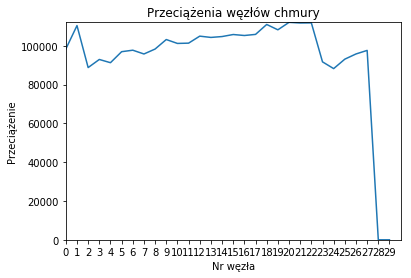

In [11]:
plt.plot(loadN)
plt.xlabel("Nr węzła")
plt.ylabel("Przeciążenie")
plt.axis([0, n, 0, max(loadN)])
plt.xticks(range(0,n))
plt.title("Przeciążenia węzłów chmury")
plt.show()